# Компоненты нелинейного процесса


Сравнение различных трендов. GPR - Gaussian Process Regression.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Regressions_sine_demo.svg/1024px-Regressions_sine_demo.svg.png)



In [1]:
from __future__ import print_function, division, unicode_literals
%pylab inline
from ipywidgets import interact
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as Constant, \
        Matern, PairwiseKernel, Exponentiation, RationalQuadratic

In [3]:
u='http://stireac.com/uskor/result.tsv/sherdim%40gmail.com/10.132.32.111__6158019760000190311'
M = pd.read_table(u)
M = M.rename(columns={'v':'code'})
M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
t       1000 non-null float64
code    1000 non-null int64
dtypes: float64(1), int64(1)
memory usage: 15.7 KB


In [4]:
R = []
for itrial in range(6):
    coab = (1000 + itrial)+1
    tab = M.t[M.code==coab].iloc[0]
    tad = M.t[(M.t>tab) & (M.code==13)].iloc[0]
    _R = M[(M.t>=tab)&(M.t<tad)].copy()
    _R['trial']=itrial+1
#     _R['d']=np.nan
    # оставляем только нажатия
    _R = _R[(_R.code > 20) & (_R.code < 100)]
    # выравниваем по времени относительно начала этапа
    _R.t -= tab
    _R.dropna(inplace=True)
    _R['iri'] = _R.t.diff()
    
    R.append(_R)
    
R = pd.concat(R)
R.shape

(445, 4)

In [5]:
R.groupby(['trial','code']).code.count()

trial  code
1      70      48
2      74      45
3      70      43
       74      43
4      70      48
       74      49
5      70      22
       74      62
6      70      60
       74      25
Name: code, dtype: int64

In [6]:
S = pd.DataFrame([
['00000000', 'одна рука'],
['11111111', 'одна рука'],
['10101010', 'поочередно'],
['01010101', 'поочередно'],
['01110111', 'паттерн'],
['10001000', 'паттерн'],
    ], columns=['pattern','тип'], index=arange(6)+1)
S

pattern         тип
1  00000000   одна рука
2  11111111   одна рука
3  10101010  поочередно
4  01010101  поочередно
5  01110111     паттерн
6  10001000     паттерн

Рисунок с нелинейными трендами.

const         a     period     noise         LML        R2
label                                                                  
00000000  0.316228  0.468774  11.904602  0.001000   89.809626  0.992049
11111111  0.316228  0.884490  17.145582  0.001000   79.314662  0.996441
10101010  0.316228  0.878500  18.083902  0.001329  134.393324  0.984965
01010101  0.316228  1.048863  33.787563  0.001992  142.915505  0.978166
01110111  0.316228  0.940359  25.941083  0.001000  138.098522  0.992745
10001000  0.640085  0.646228  13.024962  0.001472  120.531530  0.989695

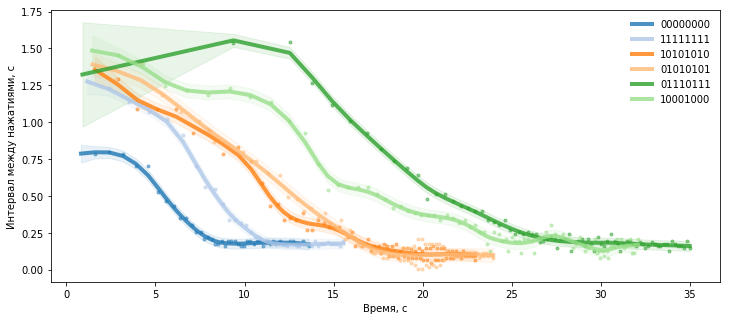

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

kernel = (Constant(1**2, (0.1, 2.)) 
        + 0.05 * Matern(length_scale=20.0, length_scale_bounds=(3, 1e3), nu=1.5)
        + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-3, 1e3))
         )
k = 1.

papa = []
coco = cm.tab20(arange(6))
for itrial, co in zip(arange(6)+1, coco):
    _R = R[R.trial==itrial]
        
    if len(_R)<5:
        continue
        
    tt = _R.t.values[1:] - _R.t.values[0]
    
    tt = tt[np.isfinite(tt)]
    vv = np.diff(tt) #_R.iri.values[1:]
    bb = vv < 1.6
    tt, vv = tt[np.r_[True, bb]], vv[bb]
    
    X = np.reshape(tt[1:],(-1,1))
    y = np.reshape(vv,(-1,1))
    gpor = GaussianProcessRegressor(kernel, alpha=1e-10, n_restarts_optimizer=0).fit(X, y)

    pa = {'label':S.loc[itrial, 'pattern']}
    pa['R2'] = gpor.score(X,y)
    pa['LML'] = gpor.log_marginal_likelihood_value_
    pa['n'] = len(vv)
    pa['totalvar'] = np.var(vv)
    _th = np.exp(gpor.kernel_.theta)
    pa['const'] = np.sqrt(_th[0])
    pa['a'] = np.sqrt(_th[1])
    pa['period'] = _th[2]
    pa['noise'] = _th[3]
    papa.append(pa)

    
    plot(tt[1:],vv,'.', color=co, alpha=.5, label='_nolegend_')

    xx = tt
    y_mean, y_std = gpor.predict(xx[:,np.newaxis], return_std=True)
    y_mean = y_mean.flatten()
    plt.plot(xx, y_mean, color=co, lw=4, alpha=.8, zorder=9, label=pa['label'])
    plt.fill_between(xx, y_mean - k * y_std, y_mean + k * y_std,
                     alpha=0.1, color=co)

plt.xlabel('Время, с');
plt.ylabel('Интервал между нажатиями, с');
# plt.ylim(0,1.2)
legend(frameon=False);
        
P = pd.DataFrame(papa)
P = P.set_index('label')
display(P[['const','a','period','noise', 'LML','R2']])

По параметру `period` можно сравнить выявленный колебательный компонент в с. Более пологий спуск соотвествует более длительному периоду колебаний.

Попробуйте поменять параметры Гауссова процесса. 

## Прогноз

Воспользуемся уже рассмотренными ранее способами оценки качества прогноза для одного из этапов.

In [15]:
import matplotlib.animation as animation
rc('animation', html='jshtml')

In [24]:
def play_prognoz(k='prognoz', n_future = 1, k0='v', interval=500):

    xx=D.index.values
    tt= xx[:-1]

    fig = figure()
    xlim(0,len(D.index)+1); ylim(0,1.5);

    hh=[]
    hh.append( plot([],[], color='b', lw=0, marker='d')[0] )
    hh.append( plot(xx[0],D[k][0], color='r', marker='*')[0] ) #prognoz
    hh.append( vlines([],[],[], colors='pink') ) #residuals

    def updatefig(i):
        hh[0].set_data(xx[:i+1], D[k0][:i+1])
        hh[1].set_data(xx[[i,i+n_future]], D[k][[i,i+n_future]])
        res1=vstack([tile(xx[i],(2,)), [D.loc[i,k0],D.loc[i,k]]]).T
        hh[2].set_segments((hh[2].get_segments() + [res1]))
                            
        return hh

    close()
    ani = animation.FuncAnimation(fig, updatefig, tt, interval=interval, blit=True, repeat=False)
    return ani



В памяти уже есть переменные для последнего 6-го этапа.

In [30]:
D = pd.DataFrame(vv, columns=['v'])#, index=tt[1:])
D['pro_gaupro'] = y_mean[1:]
play_prognoz('pro_gaupro')

In [35]:
D['pro_prev']= D.v.shift()
D['pro_median5']=D.v.rolling(5, min_periods=1).median().shift()
D['pro_mean5']=D.v.rolling(5, min_periods=1).mean().shift()
D['pro_ewma']=D.v.ewm(span=5, min_periods=1).mean().shift()
play_prognoz('pro_median5')

Сравнение качества предсказания не очень корректно, поскольку модель Гауссова процесса мы обучали на полном наборе данных (то есть с учетом будущих значений), однако для прочих способов сравнение систематических ошибок при резких скачках процесса наглядно.

In [39]:
play_prognoz('pro_ewma')

In [38]:
def quo(k):
    '''чем больше отклонение - тем ниже эффективность'''
    return 1/sqrt(mean((D.v - D[k])**2))

# vidy = [_k for _k in D.columns if _k.startswith('pro_')]
vidy = ['pro_prev', 'pro_mean5', 'pro_median5', 'pro_ewma', 'pro_gaupro']
Q = pd.Series(map(quo, vidy), index=vidy)
Q


pro_prev       16.387643
pro_mean5       9.907941
pro_median5     9.497796
pro_ewma       10.681131
pro_gaupro     20.683305
dtype: float64

In [40]:
play_prognoz('pro_prev')

Компоненты процесса можно вычитать из общей динамики, и, таким образом, строить прогнозы с учетом разных сочетаний компонентов: медленных трендов, циклов, шума.